In [146]:
import sys
import os
import gsd.hoomd
#path = "/Volumes/ALI/postdoc_project/active_nematics_defect/workspace/8c9bf534ce845303a1fb6c3ebedbbeb5"
path = "/Volumes/ALI/postdoc_project/active_nematics_defect/workspace/d82dcfb8fa035ed672d32d1bbfb85b74"
import numpy as np

In [147]:
sys.path.append("./utils")
import util

In [148]:
from importlib import reload
reload(util)

<module 'util' from './utils/util.py'>

In [10]:
import gsd.hoomd
#s = gsd.hoomd.open(name = os.path.join(path, "trajectory.gsd"), mode="rb")
#s = gsd.hoomd.open(name="test_data/new_small_file.gsd", mode="wb")
t = gsd.hoomd.open(name=os.path.join(path,"trajectory.gsd"), mode="rb")
s = gsd.hoomd.open(name="../test_data/small_file.gsd", mode="wb")
s.extend(t[500:600])
#s = gsd.hoomd.open(name="new_small_file.gsd", mode="rb")

In [149]:
#s = gsd.hoomd.open(name="../test_data/new_small_file.gsd", mode="rb")
s = gsd.hoomd.open(name="../test_data/small_file.gsd", mode="rb")

In [150]:
len(s)

100

In [151]:

sys.path.append("/Volumes/ALI/Postdoc_Project/data_analysis/freud")
import freud

snap = s[-1]
box = freud.box.Box.from_box(snap.configuration.box, dimensions=2)


cell_size = 3
r_nlist = 4
p_per_cell = 10
r_cl = 5
min_angle = 70./180.*np.pi
slice_no = 8

neigh_density = 1.
neigh_area = np.pi*(r_nlist**2)
count = int(neigh_density * neigh_area)

defect = util.defect(snap, cell_size, r_cl, slice_no,min_angle)

/Users/ali/anaconda3/envs/active_nematics/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Specifying z-dimensions in a 2-dimensional box has no effect!
  
./utils/util.py:102: UserWarning: Specifying z-dimensions in a 2-dimensional box has no effect!
  self.box = freud.box.Box.from_box(snap.configuration.box, dimensions=2)


In [152]:
from tqdm import tqdm_notebook as tqdm
folder_name = "slice_no_{}".format(slice_no)
data_folder = os.path.join("../test_data", folder_name)
if not os.path.exists(data_folder):
    os.mkdir(data_folder)
import numpy as np
from xyz import *
for i in tqdm(range(len(s))):
    snap = s[i]
    tags_p, tags_m = defect.snap_find_tags(snap, r_nlist, p_per_cell, count)
    fname_p = "defect_p_{}.xyz".format(i)
    fname_m = "defect_m_{}.xyz".format(i)
    write_xyz(open(os.path.join(data_folder,fname_p),"w"),defect.defect_position(snap,tags_p, 3), "P")
    write_xyz(open(os.path.join(data_folder,fname_m),"w"),defect.defect_position(snap,tags_m, 3), "M")

In [153]:
import sys
sys.path.append("utils/")
from track import *
from xyz import *
import os
import glob
path_folder = "../test_data/slice_no_8"

snap_No = int(len(glob.glob(os.path.join(path_folder,"*.xyz")))/2)
snap_No

frames_p = []
frames_m = []

for i in range(snap_No):
    xyz = read_xyz(open("../test_data/slice_no_8/defect_p_{}.xyz".format(i),"r"))
    frames_p.append(snap_to_trackpy(xyz.coords, i))
    xyz = read_xyz(open("../test_data/slice_no_8/defect_m_{}.xyz".format(i),"r"))
    frames_m.append(snap_to_trackpy(xyz.coords, i))

In [154]:
frames_m[0].head()

,x,y,frame
0,-89.959061,12.786400,0
1,-96.463089,15.621498,0
2,85.033836,22.532295,0
3,-65.977715,46.548637,0
4,-13.490021,45.056572,0


In [155]:
import trackpy
import pandas
tr_p = pandas.concat(trackpy.link_df_iter(frames_p, 5))
tr_m = pandas.concat(trackpy.link_df_iter(frames_m, 5))

Frame 99: 16 trajectories present.


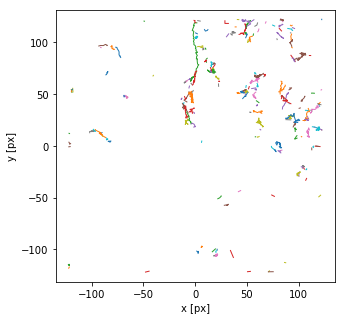

In [156]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1,1, figsize=(5,5))
trackpy.plot_traj(tr_m,ax=ax)

ax.set_ylim([-100,100])
ax.axis('equal')
plt.savefig('traj_m.png', dpi = 300, bbox_inches='tight')

In [157]:
msd_p = trackpy.imsd(tr_p,1,1)

In [158]:
msd_m = trackpy.imsd(tr_m,1,1)

In [159]:
msd_m.index

Float64Index([ 1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0, 11.0,
              12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0,
              23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0,
              34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0,
              45.0, 46.0, 47.0, 48.0, 49.0, 50.0],
             dtype='float64', name='lag time [s]')

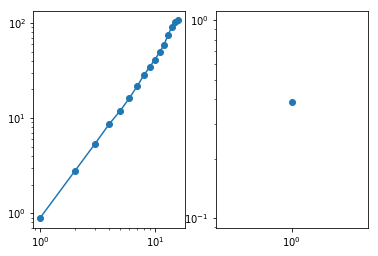

In [160]:
f, ax = plt.subplots(1,2)
ax[0].loglog(msd_p.index, msd_p[1], marker='o')
ax[1].loglog(msd_m.index, msd_m[16], marker='o')

In [161]:
x = msd_p[1].dropna()
x.dropna()
t = np.array(x.index).reshape(-1,1)
msd = np.array(x.values).reshape(-1,1)

In [162]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(np.log(t),np.log(msd))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [163]:
regr.coef_

array([[1.74499147]])

In [164]:
from sklearn import linear_model
import math
regr = linear_model.LinearRegression()
shortest_traj=5
df_p_fit = pd.DataFrame(columns = msd_p.columns, index = ['fit_slope'])
for c in msd_p.columns:
    if msd_p[c].count()>=shortest_traj:
        s = msd_p[c].dropna()
        t = np.array(s.index).reshape(-1,1)
        msd = np.array(s.values).reshape(-1,1)
        regr.fit(np.log(t), np.log(msd))
        df_p_fit[c] = float(regr.coef_)

In [165]:
df_p_fit.loc['fit_slope'].count()

107

In [166]:
shortest_traj = 5
df_m_fit = pd.DataFrame(columns = msd_m.columns, index = ['fit_slope'])
for c in msd_m.columns:
    if msd_m[c].count()>=shortest_traj:
        s = msd_m[c].dropna()
        t = np.array(s.index).reshape(-1,1)
        msd = np.array(s.values).reshape(-1,1)
        regr.fit(np.log(t), np.log(msd))
        df_m_fit[c] = float(regr.coef_)

In [167]:
df_m_fit

,0,1,3,4,5,7,8,9,10,11,...,455,459,462,464,466,468,469,471,473,477
fit_slope,NaN,1.274667,NaN,NaN,1.361057,0.712562,NaN,0.029314,1.907253,1.178251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [168]:
df_m_fit.loc['fit_slope'].count()

69

In [169]:
x_p = np.array(df_p_fit.loc['fit_slope'].dropna().astype(float).values)
x_m = np.array(df_m_fit.loc['fit_slope'].dropna().astype(float).values)

In [170]:
x_p

array([ 0.45543499,  1.74499147,  1.66035149,  1.25672668,  0.73471017,
        1.7305905 ,  1.37654545,  0.2968696 ,  1.36539796,  1.23327937,
        1.20507745,  1.07546238,  0.8747785 ,  0.32489829,  0.80051434,
        1.69666986,  1.06339429,  1.67895888,  1.31783003,  1.40625094,
        0.78675796, -0.10768989,  1.01551726,  1.28956549,  0.7125302 ,
        0.8632452 ,  1.52567023,  0.78638671,  0.8671382 ,  1.4235793 ,
        1.6908786 ,  0.88046279,  0.31393906,  1.05373528,  0.72718419,
       -0.99055158,  0.99742495,  1.74222665,  0.35655378,  1.83287799,
        0.25974799,  1.14396542,  1.35912544,  0.59359192,  0.82617263,
        0.54916133,  1.55381811,  0.77696437,  1.23522256,  0.59698075,
        1.03817183,  1.93657226,  0.33602117,  0.41934415,  1.85174369,
        1.86414875, -0.0294021 ,  0.88788638,  0.99500897,  1.75995956,
        1.45467514,  1.56141349,  1.63818314,  0.46907954,  0.96790051,
        1.39277241,  1.36357118,  1.13367332,  0.86419646,  1.29

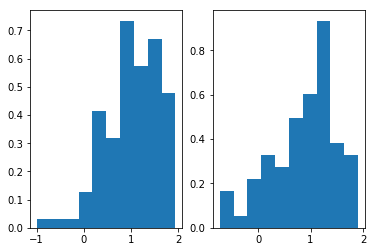

In [171]:
f, ax = plt.subplots(1,2)
ax[0].hist(x_p, bins=10, histtype='bar', density=True)
ax[1].hist(x_m, bins=10, histtype='bar', density=True)
#ax.set_ylim([0,20])
#df_m_fit.loc['fit_slope'].hist(ax=ax[1], grid=False)
plt.show()

In [74]:
max(x_p)

1.9768237828964281

In [82]:
y = np.random.randn(50)

(array([ 4.,  3.,  4.,  6.,  3.,  6.,  8., 10.,  3.,  3.]),
 array([-2.18377656, -1.78963815, -1.39549974, -1.00136133, -0.60722291,
        -0.2130845 ,  0.18105391,  0.57519232,  0.96933074,  1.36346915,
         1.75760756]),
 <a list of 10 Patch objects>)

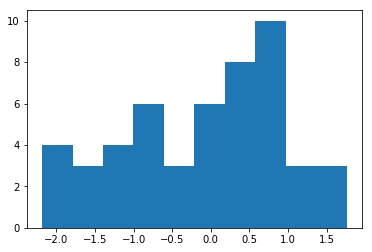

In [86]:
plt.hist(y, bins=10)